# Renderers and Plotly Visualization

This notebook demonstrates TensorTrade's rendering capabilities for visualizing trading agent performance.

## 📚 Related Tutorials

| Tutorial | Description |
|----------|-------------|
| [Architecture Overview](../docs/tutorials/01-foundations/02-architecture.md) | Understanding the TradingEnv components |
| [Observers & Feeds](../docs/tutorials/03-components/03-observers-feeds.md) | Data pipeline and feature engineering |
| [Your First Run](../docs/tutorials/01-foundations/03-your-first-run.md) | Running and understanding output |

### 🎨 Available Renderers

- **ScreenLogger**: Text output to console
- **FileLogger**: Logs to file for later analysis  
- **PlotlyTradingChart**: Interactive candlestick charts with buy/sell markers

---

# TensorTrade - Renderers and Plotly Visualization Chart
## Data Loading Function

In [ ]:
# ipywidgets and anywidget are required to run Plotly in Jupyter Notebook.
# Uncomment and run the following line to install them if required.

#!pip install ipywidgets anywidget

In [1]:
import ta

import pandas as pd

from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.wallets import Wallet, Portfolio

%matplotlib inline

In [2]:
def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp form "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    # Convert the date column type from string to datetime for proper sorting.
    df['date'] = pd.to_datetime(df['date'])

    # Make sure historical prices are sorted chronologically, oldest first.
    df.sort_values(by='date', ascending=True, inplace=True)

    df.reset_index(drop=True, inplace=True)

    # Format timestamps as you want them to appear on the chart buy/sell marks.
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')

    return df

In [3]:
df = load_csv('Coinbase_BTCUSD_1h.csv')
df.head()

/tmp/ipykernel_58/3696487257.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,date,open,high,low,close,volume
0,2017-07-01 11:00 AM,2505.56,2513.38,2495.12,2509.17,287000.32
1,2017-07-01 12:00 PM,2509.17,2512.87,2484.99,2488.43,393142.50
2,2017-07-01 01:00 PM,2488.43,2488.43,2454.40,2454.43,693254.01
3,2017-07-01 02:00 PM,2454.43,2473.93,2450.83,2459.35,712864.80
4,2017-07-01 03:00 PM,2459.35,2475.00,2450.00,2467.83,682105.41


## Data Preparation
### Create the dataset features

In [4]:
dataset = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
dataset.head(3)

,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2017-07-01 11:00 AM,2505.56,2513.38,2495.12,2509.17,287000.32,154659.537174,287000.32,0.538883,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2509.170000,0.000000,0.000000,0.000000
1,2017-07-01 12:00 PM,2509.17,2512.87,2484.99,2488.43,393142.50,-141466.449196,-106142.18,-0.207995,-8.153775e+06,...,-0.065977,-0.013195,-0.052782,2.871568,0.574314,2.297254,2500.178580,-0.826568,-0.830003,-0.826568
2,2017-07-01 01:00 PM,2488.43,2488.43,2454.40,2454.43,693254.01,-833498.148276,-799396.19,-0.606888,-1.035618e+07,...,-0.225431,-0.055643,-0.169789,12.006246,2.860700,9.145546,2480.168753,-1.366323,-1.375743,-2.181598


### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and cleaning the dataset to ensure one-to-one mapping between the historical prices data and the dataset.

In [5]:
price_history = dataset[['date', 'open', 'high', 'low', 'close', 'volume']]  # chart data
display(price_history.head(3))

dataset.drop(columns=['date', 'open', 'high', 'low', 'close', 'volume'], inplace=True)

,date,open,high,low,close,volume
0,2017-07-01 11:00 AM,2505.56,2513.38,2495.12,2509.17,287000.32
1,2017-07-01 12:00 PM,2509.17,2512.87,2484.99,2488.43,393142.50
2,2017-07-01 01:00 PM,2488.43,2488.43,2454.40,2454.43,693254.01


## Setup Trading Environment
### Create Data Feeds

In [6]:
bitfinex = Exchange("bitfinex", service=execute_order)(
    Stream.source(price_history['close'].tolist(), dtype="float").rename("USD-BTC")
)

portfolio = Portfolio(USD, [
    Wallet(bitfinex, 10000 * USD),
    Wallet(bitfinex, 10 * BTC),
])

with NameSpace("bitfinex"):
    streams = [Stream.source(dataset[c].tolist(), dtype="float").rename(c) for c in dataset.columns]

feed = DataFeed(streams)
feed.next()

{'bitfinex:/volume_adi': 154659.5371741516,
 'bitfinex:/volume_obv': 287000.32,
 'bitfinex:/volume_cmf': 0.5388828039430464,
 'bitfinex:/volume_fi': 0.0,
 'bitfinex:/volume_em': 0.0,
 'bitfinex:/volume_sma_em': 0.0,
 'bitfinex:/volume_vpt': 0.0,
 'bitfinex:/volume_vwap': 2505.89,
 'bitfinex:/volume_mfi': 50.0,
 'bitfinex:/volume_nvi': 1000.0,
 'bitfinex:/volatility_bbm': 2509.17,
 'bitfinex:/volatility_bbh': 2509.17,
 'bitfinex:/volatility_bbl': 2509.17,
 'bitfinex:/volatility_bbw': 0.0,
 'bitfinex:/volatility_bbp': 0.0,
 'bitfinex:/volatility_bbhi': 0.0,
 'bitfinex:/volatility_bbli': 0.0,
 'bitfinex:/volatility_kcc': 2505.89,
 'bitfinex:/volatility_kch': 2524.15,
 'bitfinex:/volatility_kcl': 2487.6299999999997,
 'bitfinex:/volatility_kcw': 1.457366444656407,
 'bitfinex:/volatility_kcp': 0.5898138006571786,
 'bitfinex:/volatility_kchi': 0.0,
 'bitfinex:/volatility_kcli': 0.0,
 'bitfinex:/volatility_dcl': 2495.12,
 'bitfinex:/volatility_dch': 2513.38,
 'bitfinex:/volatility_dcm': 2504.2

### Trading Environment Renderers
A renderer is a channel for the trading environment to output its current state. One or more renderers can be attached to the environment at the same time. For example, you can let the environment draw a chart and log to a file at the same time.

Notice that while all renderers can technically be used together, you need to select the best combination to avoid undesired results. For example, PlotlyTradingChart can work well with FileLogger but may not display well with ScreenLogger.

Renderer can be set by name (string) or class, single or list. Available renderers are:
* `'screenlog'` or `ScreenLogger`: Shows results on the screen.
* `'filelog'` or `FileLogger`: Logs results to a file.
* `'plotly'` or `PlotlyTradingChart`: A trading chart based on Plotly.

#### Examples:

* renderers = 'screenlog' (default)
* renderers = ['screenlog', 'filelog']
* renderers = ScreenLogger()
* renderers = ['screenlog', `FileLogger()`]
* renderers = [`FileLogger(filename='example.log')`]

Renderers can also be created and configured first then attached to the environment as seen in a following example.

### Trading Environment with a Single Renderer

In [7]:
import tensortrade.env.default as default

env = default.create(
    portfolio=portfolio,
    action_scheme="simple",  # Changed from "managed-risk" - simpler discrete actions
    reward_scheme="simple",  # Changed from "risk-adjusted" 
    feed=feed,
    renderer="screen-log",  # ScreenLogger used with default settings
    window_size=20
)

In [8]:
# Run environment with random actions to demonstrate the renderer
# Note: DQNAgent is deprecated in favor of Ray RLlib

obs, info = env.reset()
done = truncated = False
total_reward = 0
step = 0

while not done and not truncated and step < 200:
    action = env.action_space.sample()  # Random action
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step += 1
    if step % 10 == 0:
        env.render()

print(f"Episode finished after {step} steps with total reward: {total_reward}")

[2026-02-07 23:57:02] Step: 11/
[2026-02-07 23:57:02] Step: 21/
[2026-02-07 23:57:02] Step: 31/
[2026-02-07 23:57:02] Step: 41/
[2026-02-07 23:57:02] Step: 51/
[2026-02-07 23:57:02] Step: 61/
[2026-02-07 23:57:02] Step: 71/
[2026-02-07 23:57:02] Step: 81/
[2026-02-07 23:57:02] Step: 91/
[2026-02-07 23:57:02] Step: 101/
[2026-02-07 23:57:02] Step: 111/
[2026-02-07 23:57:02] Step: 121/
[2026-02-07 23:57:02] Step: 131/
[2026-02-07 23:57:02] Step: 141/
[2026-02-07 23:57:02] Step: 151/
[2026-02-07 23:57:02] Step: 161/
[2026-02-07 23:57:02] Step: 171/
[2026-02-07 23:57:02] Step: 181/
[2026-02-07 23:57:02] Step: 191/
[2026-02-07 23:57:02] Step: 201/
Episode finished after 200 steps with total reward: 0.020711275216247715


### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

In [9]:
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger

chart_renderer = PlotlyTradingChart(
    display=False,  # Disable interactive widget display (avoids anywidget issues)
    height=800,  # affects both displayed and saved file height. None for 100% height.
    save_format="html",  # save the chart to an HTML file
    auto_open_html=True,  # open the saved HTML chart in a new browser tab
)

file_logger = FileLogger(
    filename="example.log",  # omit or None for automatic file name
    path="training_logs"  # create a new directory if doesn't exist, None for no directory
)

### Environement with Multiple Renderers

With the plotly renderer you must provide an parameter called `renderer_feed`. This is a `DataFeed` instance that provides all the information that is required by a renderer to function.

In [10]:
renderer_feed = DataFeed([
    Stream.source(price_history[c].tolist(), dtype="float").rename(c) for c in price_history]
)

env = default.create(
    portfolio=portfolio,
    action_scheme="simple",  # Changed from "managed-risk"
    reward_scheme="simple",  # Changed from "risk-adjusted"
    feed=feed,
    window_size=20,
    renderer_feed=renderer_feed,
    renderer=[
        chart_renderer, 
        file_logger
    ]
)

In [11]:
!pip install anywidget

## Setup and Train DQN Agent
The green and red arrows shown on the chart represent buy and sell trades respectively. The head of each arrow falls at the trade execution price.

In [12]:
# Run environment with random actions to demonstrate the chart renderer
# Note: DQNAgent is deprecated in favor of Ray RLlib

obs, info = env.reset()
done = truncated = False
total_reward = 0
step = 0

while not done and not truncated and step < 200:
    action = env.action_space.sample()  # Random action
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step += 1

# Render the final chart
env.render()
print(f"Episode finished after {step} steps with total reward: {total_reward}")

INFO:02708bad-46ba-40c7-a9b9-41a3a00baeb4:[2026-02-07 23:57:05] Step: 201/ - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17              10000.0                    0.0   
1              2488.43              10000.0                    0.0   
2              2454.43               4000.0                    0.0   
3              2459.35               2800.0                    0.0   
4              2467.83                  0.0                    0.0   
..                 ...                  ...                    ...   
196            2559.32                  0.0                    0.0   
197            2555.67                  0.0                    0.0   
198            2553.79                  0.0                    0.0   
199            2539.82                  0.0                    0.0   
200            2542.72                  0.0                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfinex:/BTC:/locked

Episode finished after 200 steps with total reward: 0.018887045483142906


## Direct Performance and Net Worth Plotting
Alternatively, the final performance and net worth can be displayed using pandas via Matplotlib.

<Axes: >

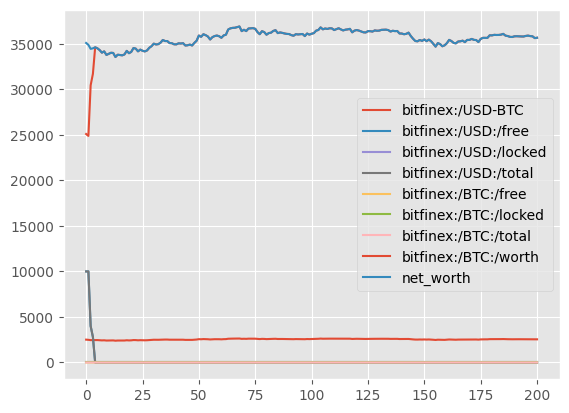

In [13]:
%matplotlib inline

performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
performance.plot()

<Axes: >

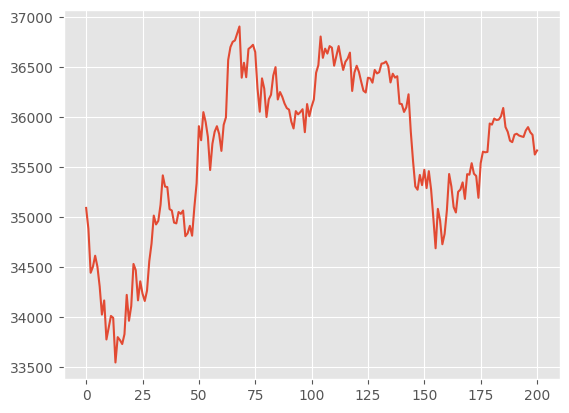

In [14]:
performance.net_worth.plot()